In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
import random


In [19]:
def train_test_split(data):
  train_size = int(len(data)*0.5)
  xtrain, xtest = data[:train_size], data[train_size:]
  return xtrain, xtest

def auto_model(xtrain):
  optimal_model = auto_arima(xtrain[:, 0],
                        exogenous= xtrain[:, 1:],
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  return optimal_model

def sarimax_model (xtrain, order, seasonal_order):
  sarimax_model = SARIMAX(xtrain[:, 0],
                        exog=xtrain[:, 1:],
                        order = order,
                        seasonal_order = seasonal_order)
  return sarimax_model

def create_sequence(df, step):
  X = []
  Y = []
  for i in range(len(df)):
    end_index = i+step
    if end_index > len(df)-1:
      break
    x_value = df[i:end_index, :]
    y_value = df[end_index, 0]
    X.append(x_value)
    Y.append(y_value)
  return np.array(X), np.array(Y)

def reinitialize(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            for weight in layer.weights:
                if 'kernel' in weight.name:
                    weight.assign(tf.keras.initializers.GlorotUniform()(weight.shape))
                elif 'recurrent_kernel' in weight.name:
                    weight.assign(tf.keras.initializers.Orthogonal()(weight.shape))
                elif 'bias' in weight.name:
                    weight.assign(tf.keras.initializers.Zeros()(weight.shape))
        elif isinstance(layer, tf.keras.layers.Dense):
            layer.kernel.assign(tf.keras.initializers.GlorotUniform()(layer.kernel.shape))
            if layer.bias is not None:
                layer.bias.assign(tf.keras.initializers.Zeros()(layer.bias.shape))

In [112]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
cluster_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/clustered_forecast_data.xlsx').drop(columns=['Unnamed: 0'])

In [6]:
print(cluster_df.head())

        Year      Country   Emission  Fertlizer_consumption  Temperature  \
0 1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1 1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2 1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3 1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4 1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [7]:
china_df = cluster_df[cluster_df['Country']=='China'].drop(columns=['Cluster', 'Country'])
china_df.set_index('Year', inplace=True)

In [8]:
us_df = cluster_df[cluster_df['Country']=='United States'].drop(columns=['Cluster', 'Country'])
us_df.set_index('Year', inplace=True)

In [11]:
for col in china_df.columns:
    result = adfuller(china_df[col])
    print('p-value:', result[1])

p-value: 0.43705876632596996
p-value: 0.3591085281434667
p-value: 0.9830421590144939


In [58]:
for col in us_df.columns:
    result = adfuller(us_df[col])
    print('p-value:', result[1])

p-value: 0.00013000309999711617
p-value: 0.027588015851474086
p-value: 0.8604558151280166


In [13]:
scaler = StandardScaler()
scaled_china_df = scaler.fit_transform(china_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_china_df)

[[-1.639809   -1.72974923 -0.49242438]
 [-1.61894212 -1.69508566 -1.05668443]
 [-1.57558301 -1.6736401  -0.56592807]
 [-1.51535014 -1.63762775 -0.7787163 ]
 [-1.45578867 -1.56155672 -1.02151465]
 [-1.3780741  -1.45095699 -0.98733475]
 [-1.37787268 -1.54307847 -1.74241199]
 [-1.35103239 -1.51731683 -1.18818726]
 [-1.31729768 -1.45163138 -1.36795121]
 [-1.26264032 -1.35276601 -1.43526576]
 [-1.23038446 -1.35114748 -0.99923788]
 [-1.17725094 -1.28397838 -1.10531926]
 [-1.12197311 -1.20251224 -0.45582215]
 [-1.11911698 -1.28654106 -1.16680471]
 [-1.04687308 -1.11834854 -0.34749137]
 [-1.04495905 -1.1561143  -1.4770527 ]
 [-0.91353138 -0.84117483 -1.10064841]
 [-0.77011885 -0.54066728 -0.54920639]
 [-0.68268482 -0.3553453  -0.5782699 ]
 [-0.57475211 -0.15491701 -0.75116722]
 [-0.62913948 -0.2451502  -0.7027838 ]
 [-0.57869966 -0.22330001 -0.34416606]
 [-0.47516172 -0.12969488 -0.85620317]
 [-0.3792029  -0.06198626 -1.24103514]
 [-0.43765434 -0.30678932 -1.13895411]
 [-0.40950305 -0.35251286

In [15]:
xtrain,xtest = train_test_split(scaled_china_df)

In [18]:
optimal_model = auto_model(xtrain)
print(optimal_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.581, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.164 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  42.878
Date:                Thu, 25 Jul 2024   AIC                            -81.755
Time:                        21:27:51   BIC                            -79.021
Sample:                             0   HQIC                           -80.899
                    

In [20]:
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
sarimax_model1 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model1_fit = sarimax_model1.fit()

In [50]:
sarimax_model1_forecast = sarimax_model1_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [52]:
mse = mean_squared_error(xtest[:, 0], sarimax_model1_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(xtest[:, 0], sarimax_model1_forecast)
print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  0.5594077695219328
MAPE :  0.5890808796591636


In [53]:
sarimax_model1_forecast = sarimax_model1_forecast.reshape(sarimax_model1_forecast.shape[0], -1)

In [54]:
forecast_copy = np.repeat(sarimax_model1_forecast, 3, axis=-1)
sarimax_model1_forecast = scaler.inverse_transform(forecast_copy)[:, 0]

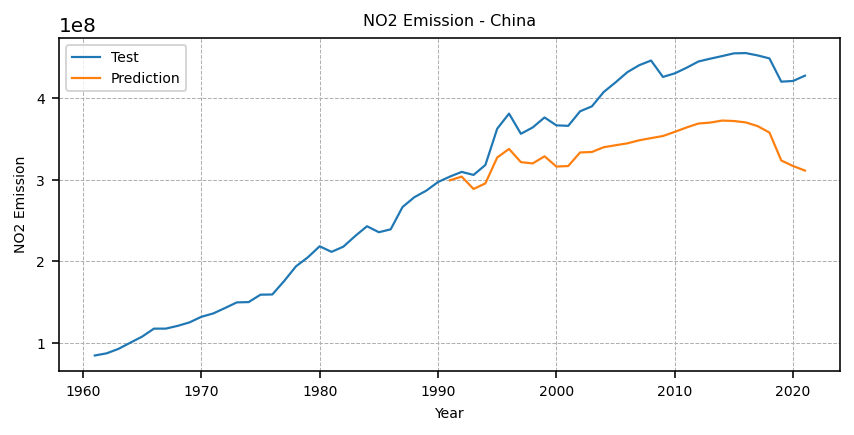

In [55]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index, china_df['Emission'], label="Test",
            linewidth = 1.1)
plt.plot(china_df.index[len(xtrain):], sarimax_model1_forecast, label='Prediction',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()


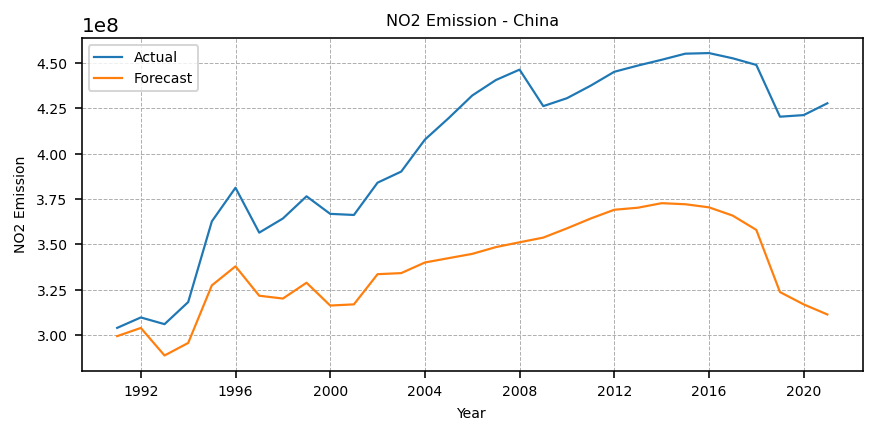

In [56]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[len(xtrain):], china_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(china_df.index[len(xtrain):], sarimax_model1_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

In [59]:
scaler = StandardScaler()
scaled_us_df = scaler.fit_transform(us_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_us_df)

[[-3.3456788  -2.43534799 -1.1749111 ]
 [-2.81988293 -2.26043599 -0.68877155]
 [-2.17680172 -2.12885805 -0.48591404]
 [-1.62292749 -2.01146216 -1.2916514 ]
 [-0.962459   -1.82630756 -1.15676182]
 [-0.36953665 -1.58994    -1.32442176]
 [ 0.29827587 -1.33623881 -0.76590404]
 [ 0.71278535 -1.29763211 -1.26237015]
 [ 1.08545013 -1.27320746 -0.90159904]
 [ 0.69645169 -1.08174973 -0.99552802]
 [ 0.84735106 -1.02974886 -1.38375216]
 [ 1.07784921 -0.977748   -1.46599085]
 [ 1.59844289 -0.76895665 -0.5744866 ]
 [ 1.27000237 -0.78786605 -0.68436286]
 [ 1.34399846 -0.47507298 -1.34626189]
 [ 2.09103745 -0.24500854 -1.06227765]
 [ 1.84009271 -0.36398022 -0.06346978]
 [ 1.88873733 -0.3174946  -0.89086899]
 [ 1.76165074 -0.103188   -1.02621993]
 [ 1.09326221  0.06936032 -0.24707545]
 [ 0.90589161 -0.06852076  0.64381105]
 [ 0.06320791 -0.52234649 -1.20783472]
 [ 0.27225744 -0.31040357 -0.55596667]
 [ 0.4812825  -0.03385352 -0.80929966]
 [ 0.12416846 -0.20955341 -1.091806  ]
 [-0.19845609 -0.35925287

In [60]:
xtrain,xtest = train_test_split(scaled_us_df)

In [61]:
optimal_model = auto_model(xtrain)
print(optimal_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=105.974, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.918, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.558, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.301, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=38.739, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.339, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=40.105, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=40.567, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=42.233, Time=0.44 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39.765, Time=0.24 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 3.140 seconds
                               SARIMAX Results                                
Dep. Variable:                      y 

In [62]:
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
sarimax_model2 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model2_fit = sarimax_model2.fit()

In [63]:
sarimax_model2_forecast = sarimax_model2_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [65]:
mse = mean_squared_error(xtest[:, 0], sarimax_model2_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(xtest[:, 0], sarimax_model2_forecast)
print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  1.0433494365028964
MAPE :  9.170794320019194


In [67]:
sarimax_model2_forecast = sarimax_model2_forecast.reshape(sarimax_model1_forecast.shape[0], -1)

In [68]:
forecast_copy = np.repeat(sarimax_model2_forecast, 3, axis=-1)
sarimax_model2_forecast = scaler.inverse_transform(forecast_copy)[:, 0]

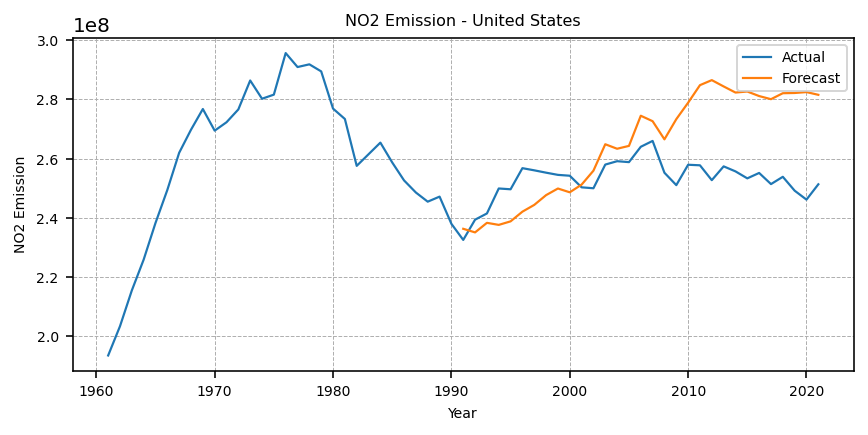

In [69]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index, us_df['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(us_df.index[len(xtrain):], sarimax_model2_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

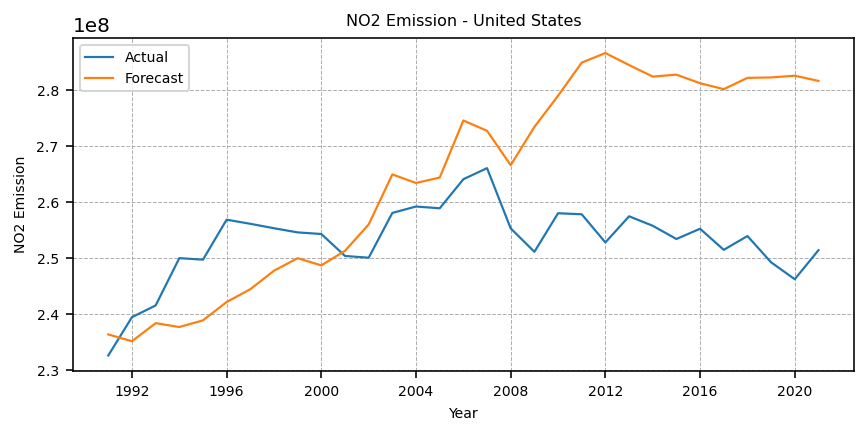

In [70]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[len(xtrain):], us_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(us_df.index[len(xtrain):], sarimax_model2_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

In [84]:
scaler = StandardScaler()
scaled_china_df = scaler.fit_transform(china_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_china_df)

[[-1.639809   -1.72974923 -0.49242438]
 [-1.61894212 -1.69508566 -1.05668443]
 [-1.57558301 -1.6736401  -0.56592807]
 [-1.51535014 -1.63762775 -0.7787163 ]
 [-1.45578867 -1.56155672 -1.02151465]
 [-1.3780741  -1.45095699 -0.98733475]
 [-1.37787268 -1.54307847 -1.74241199]
 [-1.35103239 -1.51731683 -1.18818726]
 [-1.31729768 -1.45163138 -1.36795121]
 [-1.26264032 -1.35276601 -1.43526576]
 [-1.23038446 -1.35114748 -0.99923788]
 [-1.17725094 -1.28397838 -1.10531926]
 [-1.12197311 -1.20251224 -0.45582215]
 [-1.11911698 -1.28654106 -1.16680471]
 [-1.04687308 -1.11834854 -0.34749137]
 [-1.04495905 -1.1561143  -1.4770527 ]
 [-0.91353138 -0.84117483 -1.10064841]
 [-0.77011885 -0.54066728 -0.54920639]
 [-0.68268482 -0.3553453  -0.5782699 ]
 [-0.57475211 -0.15491701 -0.75116722]
 [-0.62913948 -0.2451502  -0.7027838 ]
 [-0.57869966 -0.22330001 -0.34416606]
 [-0.47516172 -0.12969488 -0.85620317]
 [-0.3792029  -0.06198626 -1.24103514]
 [-0.43765434 -0.30678932 -1.13895411]
 [-0.40950305 -0.35251286

In [85]:
x, y = create_sequence(scaled_china_df, 5)
print(x)
print(y)

[[[-1.639809   -1.72974923 -0.49242438]
  [-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]]

 [[-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]]

 [[-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]]

 [[-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]]

 [[-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]
  [-1.31729768 -1.45163138 -1.36

In [86]:
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [87]:
lstm_model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(32, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [23]:
optimizers = ['SGD', 'adam', 'RMSprop']
learning_rate = np.linspace(0.0001, 0.01, 4)
hist = []
for opt in optimizers:
  for rate in learning_rate:
      reinitialize(lstm_model1)
      lstm_model1.compile(optimizer=opt, loss='mse',  metrics=['mae'])
      lstm_model1.optimizer.learning_rate = rate
      print("")
      print(f"optimizer: {opt}    learning rate: {rate}")
      print("")
      history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100)
      hist.append(history)


optimizer: SGD    learning rate: 0.0001

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.7339 - mae: 0.7188 - val_loss: 1.0271 - val_mae: 0.9684
Epoch 2/100
1/1 [==============================] - 0s 70ms/step - loss: 0.7337 - mae: 0.7187 - val_loss: 1.0274 - val_mae: 0.9685
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.7334 - mae: 0.7186 - val_loss: 1.0277 - val_mae: 0.9687
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 0.7331 - mae: 0.7184 - val_loss: 1.0280 - val_mae: 0.9688
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.7329 - mae: 0.7183 - val_loss: 1.0283 - val_mae: 0.9690
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.7326 - mae: 0.7181 - val_loss: 1.0286 - val_mae: 0.9691
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 0.7323 - mae: 0.7180 - val_loss: 1.0289 - val_mae: 0.9693
Epoch 8/100
1/1 [==============================] -

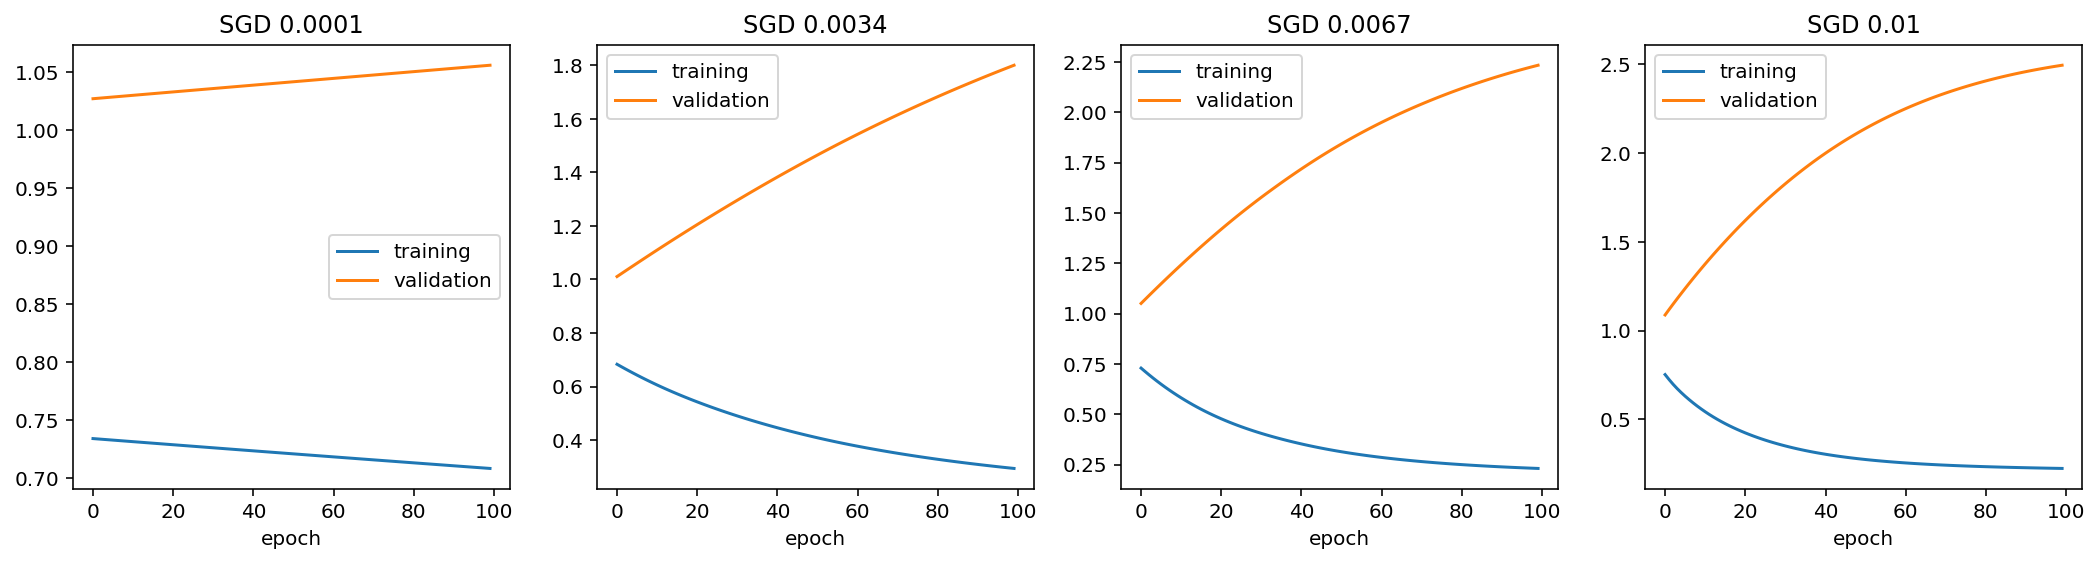

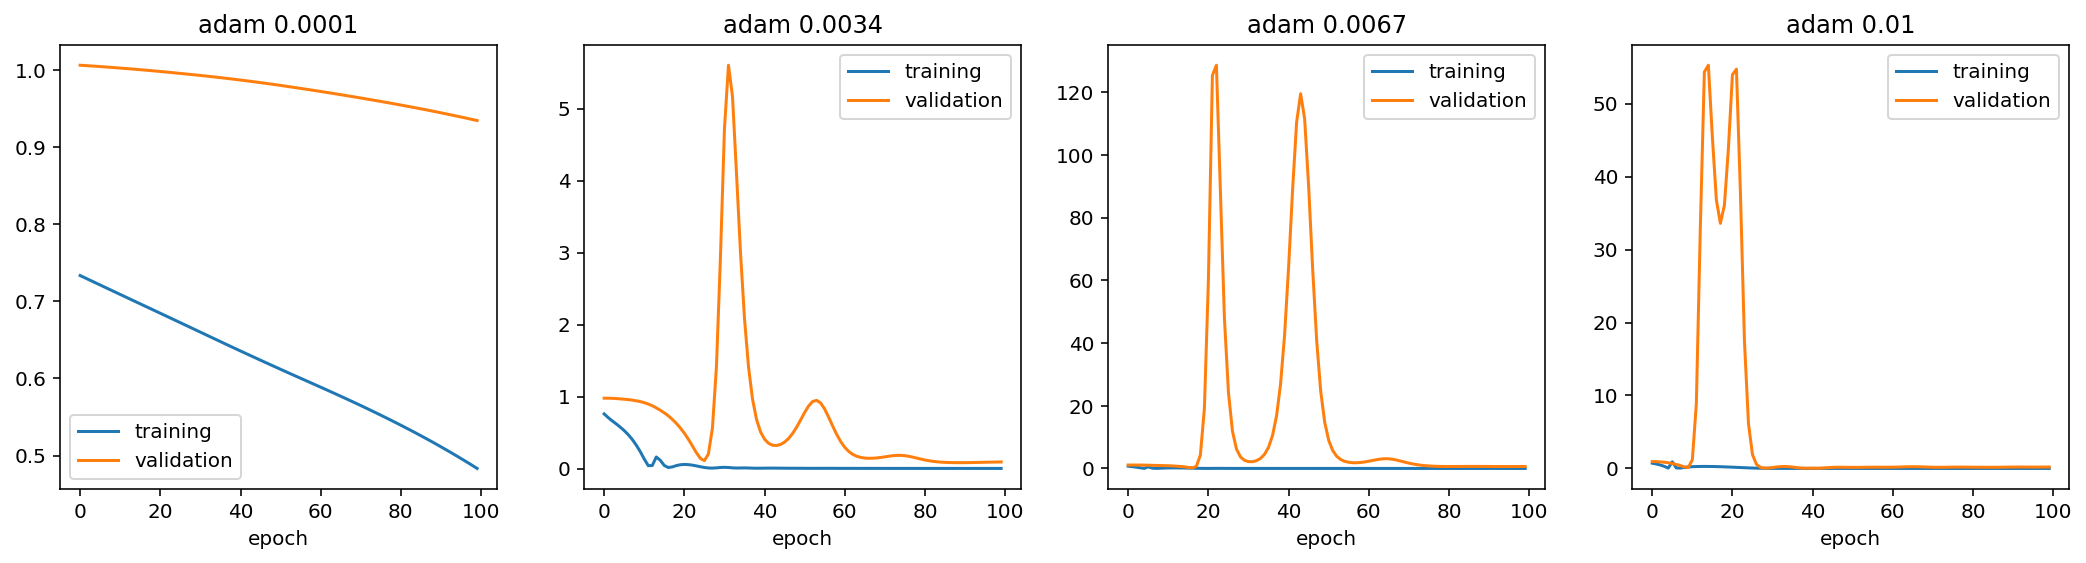

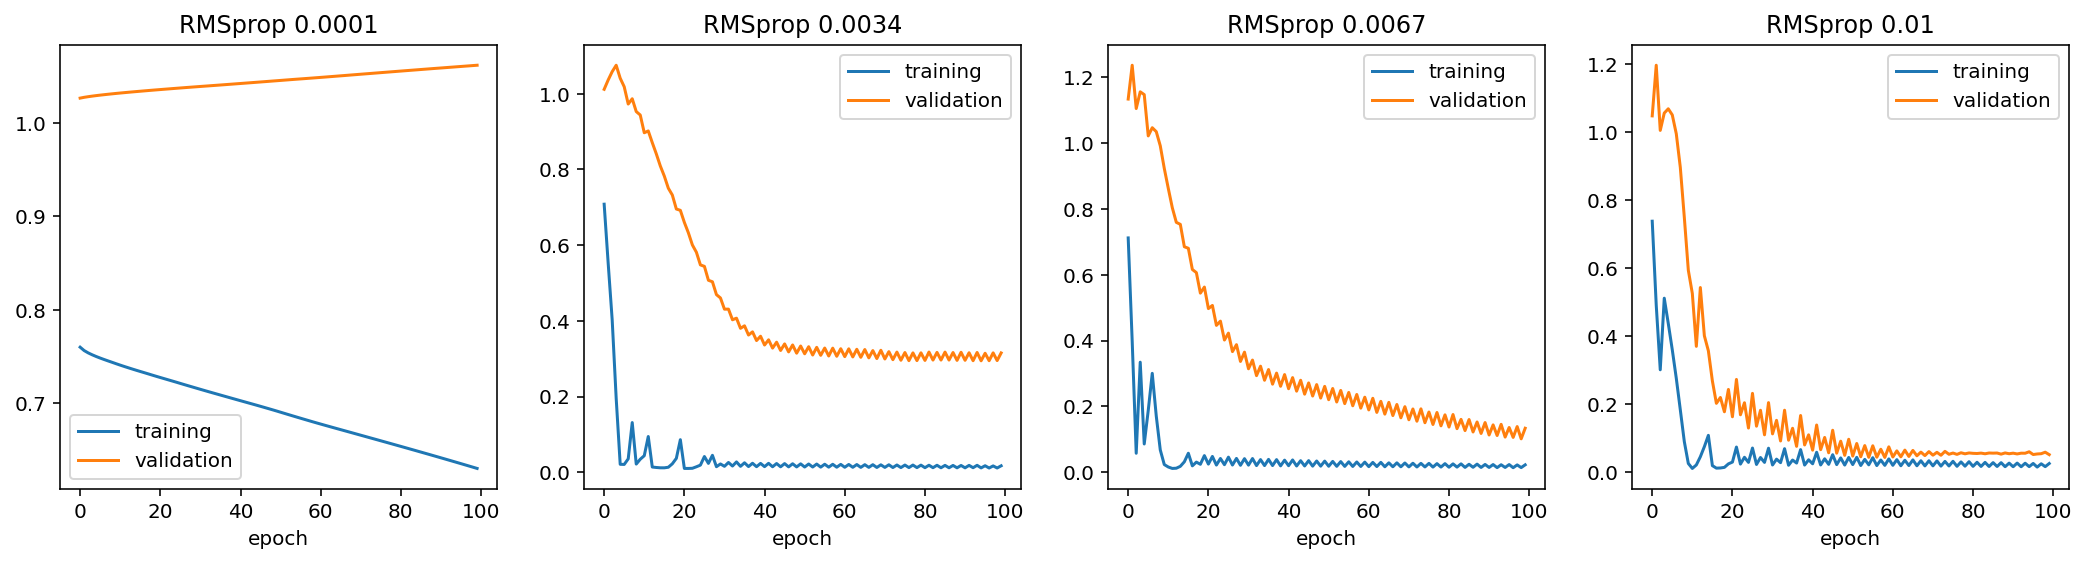

In [24]:
count = 0
for o in range(len(optimizers)):
  f, ax = plt.subplots(1, 4, figsize=(18,4), dpi=144)
  ax = ax.flatten()
  for r in range(len(learning_rate)):
      ax[r].plot(hist[count].history['loss'], label="training")
      ax[r].plot(hist[count].history['val_loss'], label="validation")
      ax[r].set_title(f"{optimizers[o]} {learning_rate[r].round(5)}")
      ax[r].set_xlabel("epoch")
      ax[r].legend()
      count = count + 1

  plt.show()

In [90]:
reinitialize(lstm_model1)
hist = []
lstm_model1.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model1.optimizer.learning_rate = 0.01
history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
hist.append(history)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 1.1082 - val_mae: 1.0144
Epoch 2/150
1/1 [==============================] - 0s 40ms/step - loss: 0.3542 - mae: 0.5027 - val_loss: 1.2805 - val_mae: 1.1057
Epoch 3/150
1/1 [==============================] - 0s 38ms/step - loss: 2.6234 - mae: 1.4437 - val_loss: 1.0405 - val_mae: 0.9790
Epoch 4/150
1/1 [==============================] - 0s 46ms/step - loss: 0.4500 - mae: 0.5599 - val_loss: 1.0493 - val_mae: 0.9848
Epoch 5/150
1/1 [==============================] - 0s 37ms/step - loss: 0.3901 - mae: 0.5221 - val_loss: 1.0439 - val_mae: 0.9823
Epoch 6/150
1/1 [==============================] - 0s 39ms/step - loss: 0.3575 - mae: 0.5003 - val_loss: 1.0480 - val_mae: 0.9850
Epoch 7/150
1/1 [==============================] - 0s 39ms/step - loss: 0.3261 - mae: 0.4792 - val_loss: 1.0260 - val_mae: 0.9740
Epoch 8/150
1/1 [==============================] - 0s 40ms/step - loss: 0.2916 - mae: 0.4522

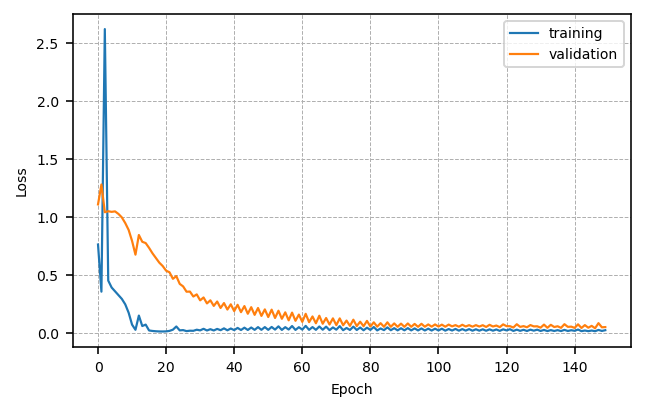

In [91]:
plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epoch", fontsize=7)
plt.ylabel("Loss", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [92]:
lstm_model1_forecast = lstm_model1.predict(x_test)

1/1 [==============================] - 0s 293ms/step


In [93]:
mse = mean_squared_error(y_test, lstm_model1_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, lstm_model1_forecast)
print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  0.219207767802606
MAPE :  0.2221759108453645


In [95]:
prediction_copy = np.repeat(lstm_model1_forecast, 3, axis=-1)
lstm_model1_forecast = scaler.inverse_transform(prediction_copy)[:, 0]

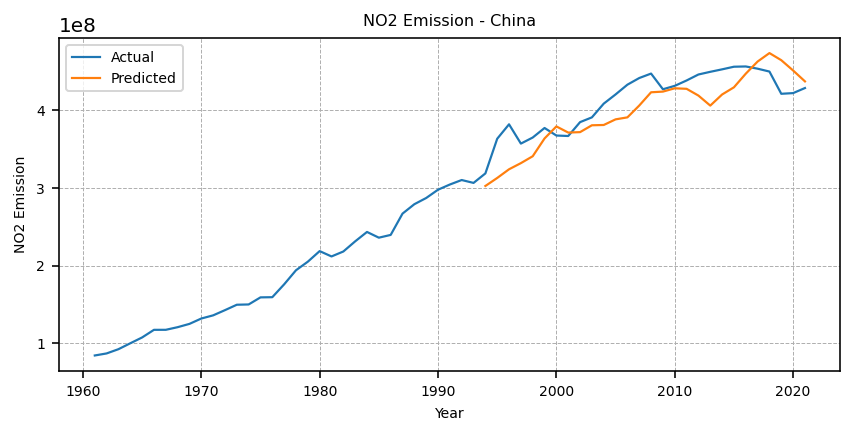

In [96]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index, china_df.iloc[:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], lstm_model1_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

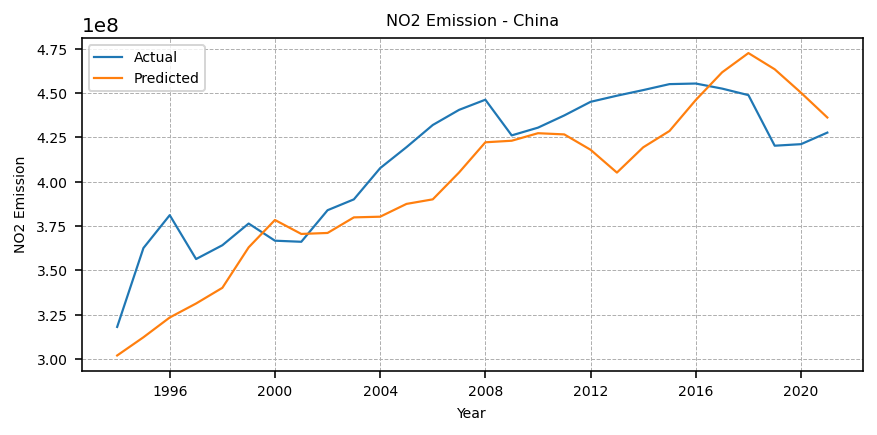

In [97]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], lstm_model1_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

In [98]:
scaler = StandardScaler()
scaled_us_df = scaler.fit_transform(us_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_us_df)

[[-3.3456788  -2.43534799 -1.1749111 ]
 [-2.81988293 -2.26043599 -0.68877155]
 [-2.17680172 -2.12885805 -0.48591404]
 [-1.62292749 -2.01146216 -1.2916514 ]
 [-0.962459   -1.82630756 -1.15676182]
 [-0.36953665 -1.58994    -1.32442176]
 [ 0.29827587 -1.33623881 -0.76590404]
 [ 0.71278535 -1.29763211 -1.26237015]
 [ 1.08545013 -1.27320746 -0.90159904]
 [ 0.69645169 -1.08174973 -0.99552802]
 [ 0.84735106 -1.02974886 -1.38375216]
 [ 1.07784921 -0.977748   -1.46599085]
 [ 1.59844289 -0.76895665 -0.5744866 ]
 [ 1.27000237 -0.78786605 -0.68436286]
 [ 1.34399846 -0.47507298 -1.34626189]
 [ 2.09103745 -0.24500854 -1.06227765]
 [ 1.84009271 -0.36398022 -0.06346978]
 [ 1.88873733 -0.3174946  -0.89086899]
 [ 1.76165074 -0.103188   -1.02621993]
 [ 1.09326221  0.06936032 -0.24707545]
 [ 0.90589161 -0.06852076  0.64381105]
 [ 0.06320791 -0.52234649 -1.20783472]
 [ 0.27225744 -0.31040357 -0.55596667]
 [ 0.4812825  -0.03385352 -0.80929966]
 [ 0.12416846 -0.20955341 -1.091806  ]
 [-0.19845609 -0.35925287

In [99]:
x, y = create_sequence(scaled_us_df, 5)

In [100]:
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [101]:
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(64, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [102]:
reinitialize(lstm_model2)
hist = []
lstm_model2.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model2.optimizer.learning_rate = 0.01
history = lstm_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
hist.append(history)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 1.1664 - mae: 0.9205 - val_loss: 0.0830 - val_mae: 0.2383
Epoch 2/150
1/1 [==============================] - 0s 43ms/step - loss: 0.7784 - mae: 0.7571 - val_loss: 0.0999 - val_mae: 0.2741
Epoch 3/150
1/1 [==============================] - 0s 42ms/step - loss: 2.6092 - mae: 1.4993 - val_loss: 0.0496 - val_mae: 0.1723
Epoch 4/150
1/1 [==============================] - 0s 40ms/step - loss: 1.0631 - mae: 0.8858 - val_loss: 0.0510 - val_mae: 0.1778
Epoch 5/150
1/1 [==============================] - 0s 39ms/step - loss: 0.8814 - mae: 0.8013 - val_loss: 0.0490 - val_mae: 0.1743
Epoch 6/150
1/1 [==============================] - 0s 45ms/step - loss: 0.8205 - mae: 0.7734 - val_loss: 0.0467 - val_mae: 0.1699
Epoch 7/150
1/1 [==============================] - 0s 40ms/step - loss: 0.7619 - mae: 0.7462 - val_loss: 0.0471 - val_mae: 0.1674
Epoch 8/150
1/1 [==============================] - 0s 53ms/step - loss: 0.6998 - mae: 0.7138

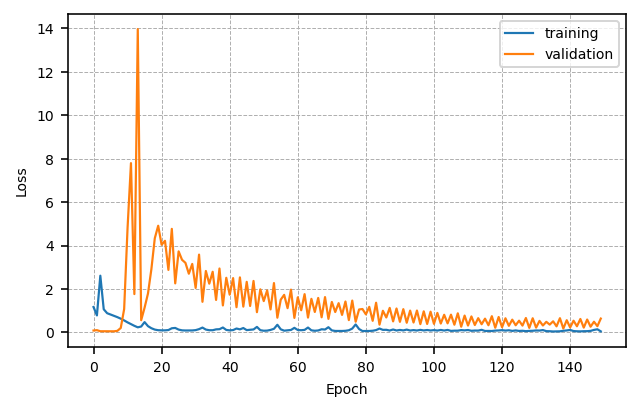

In [103]:

plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epoch", fontsize=7)
plt.ylabel("Loss", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [105]:
lstm_model2_forecast = lstm_model2.predict(x_test)

1/1 [==============================] - 0s 358ms/step


In [106]:
mse = mean_squared_error(y_test, lstm_model2_forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, lstm_model2_forecast)
print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  0.7960539650953651
MAPE :  8.412526913302738


In [107]:
prediction_copy = np.repeat(lstm_model2_forecast, 3, axis=-1)
lstm_model2_forecast = scaler.inverse_transform(prediction_copy)[:, 0]

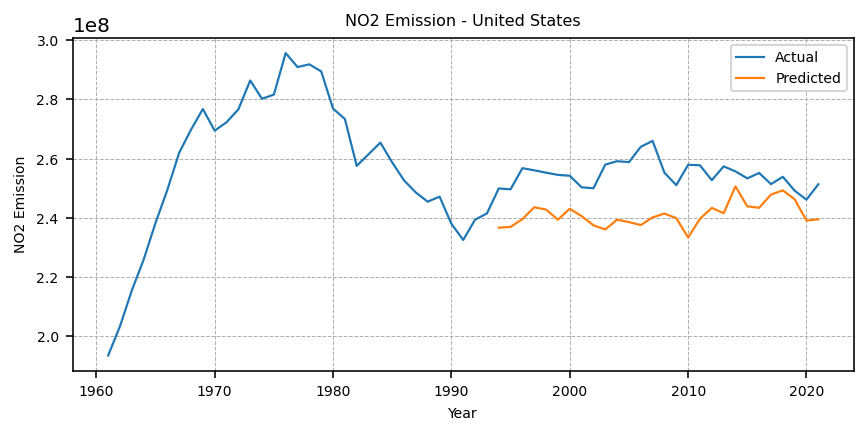

In [108]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index, us_df.iloc[:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], lstm_model2_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

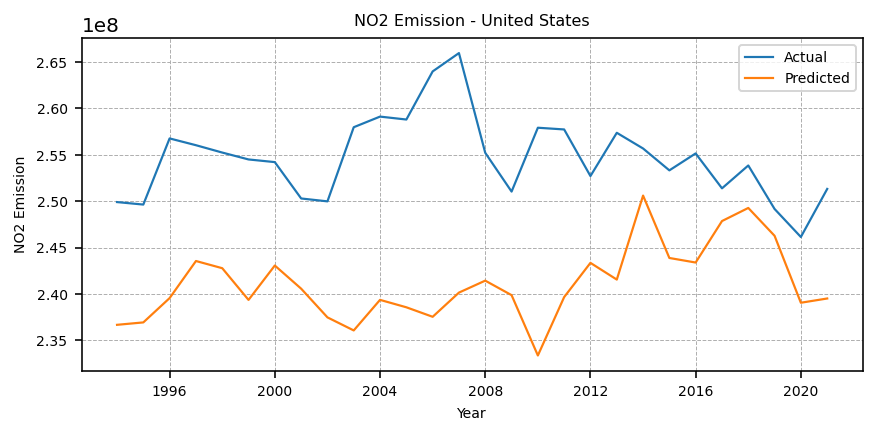

In [109]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], lstm_model2_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()